<a href="https://colab.research.google.com/github/chlolv/NLP_Lavest_Chabriel/blob/main/Main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package and definitions


In [1]:
# BERT
# bi LSTM
# Hierarchical cross-entropy ?
# Bonne matrice de confusion

import requests as req
import pandas as pd
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
try :
  import transformers
except :
  !pip install transformers
  import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from itertools import compress
import seaborn as sns
from tqdm import *
import time

# torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))

git_url = "https://raw.githubusercontent.com/chlolv/NLP_Project/main/Data/"
H_url = "H_series.csv"
book_url = "book_labels.csv"

# temp fixes due to csv use
H = req.get(git_url + H_url)
H = re.sub('\n\d{0,9}[0-9],',
           '\n', H.text[7:])
words = ["He-", "\\\\", '"', '"', "o-"]
H = re.sub("".join(words), "He-Who", H)
H = re.sub("\*", "" , H)
H = H.split('\n')

     |████████████████████████████████| 4.0 MB 5.7 MB/s 
     |████████████████████████████████| 6.6 MB 16.1 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 35.0 MB/s 
     |████████████████████████████████| 895 kB 16.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
DEVICE =  Tesla K80


# Creation of labels

The unit of observation is a paragraph of one of the books of the Harry Potter series. The label that will be predicted by the algorithm is the presence of one of the main characters of the series inside a paragraph. However, several characters can coexist in a similar paragraph, that contradicts the principle of a unique label for a unique paragraph. We thus resort to build compounded labels that match all the characters present in the excerpt. 

In [2]:
character_list = {1: ['Harry', 'Potter'], 2: ['Ron', 'Weasley'], 3: ['Hermione', 'Granger'], 4: ['Snape', 'Severus'], 
                  5:['Albus', 'Dumbledore'], 6: ['Dursley', 'Vernon', 'Dudley', 'Petunia'], 7: ['Draco', 'Malfoy']}
paragraph_character_labels = []
para_id = 0
for paragraph in tqdm_notebook(H) :
  paragraph_character_labels.append('')
  for key in character_list.keys() :
    character = character_list[key]
    if any(name in paragraph for name in character) :
      if paragraph_character_labels[para_id] != '' :
        paragraph_character_labels[para_id] += '_'
      paragraph_character_labels[para_id] += character[0]
  if paragraph_character_labels[para_id] == '' :
    paragraph_character_labels[para_id] += 'None'
  para_id += 1
pd.DataFrame.from_dict(Counter(paragraph_character_labels), orient = 'index').sort_values(by = [0], ascending = [False])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20931 [00:00<?, ?it/s]

,0
Harry,5214
None,3759
Harry_Ron,1758
Harry_Ron_Hermione,1438
Ron,1159
...,...
Ron_Albus_Draco,2
Ron_Hermione_Snape_Draco,2
Ron_Dursley_Draco,1
Harry_Ron_Hermione_Albus_Dursley,1


We then resort to mask all giveaway information, especially proper nouns, to prevent future overfitting. 

In [3]:
# On masque les noms propres 
special_data = []
for paragraph in tqdm_notebook(H) :
  tokenized = nltk.word_tokenize(paragraph)
  proper_nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if pos in ['NNP', 'NNPS']] 
  for proper_noun in proper_nouns :
    paragraph = re.sub(proper_noun, 'charoffocus', paragraph)
    paragraph = re.sub('Dumbledore', 'charoffocus', paragraph)
    paragraph = re.sub('dumbledore', 'charoffocus', paragraph)
    paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
    paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
    paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
  special_data.append(paragraph)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/20931 [00:00<?, ?it/s]

Writing data for further use.

In [4]:
textfile = open("special_data.txt", "w")
for element in special_data:
    textfile.write(element + "\n")
textfile.close()

We create an *Other* category, to assemble data categories with unsufficient appearances for future predictions. 

In [5]:
seed = 42
stratify_labels = []
labels = paragraph_character_labels

counted_data = pd.DataFrame.from_dict(Counter(paragraph_character_labels), orient = 'index').sort_values(by = [0], ascending = [False])
data_that_matters = counted_data.index[(counted_data[0] > 500) & (counted_data.index != 'None')]

# on met en Other les catégories trop petites
for i in range(0, len(labels)) :
  if labels[i] in data_that_matters :
    new_label = labels[i]
  else :
    new_label = 'Other'
  stratify_labels.append(new_label)

liste_unique_labels = np.unique(stratify_labels)
correspondance_label_numeric = list(range(0, len(np.unique(stratify_labels))))
numeric_stratify_labels = pd.DataFrame(stratify_labels).replace(liste_unique_labels, correspondance_label_numeric)
numeric_stratify_labels = list(numeric_stratify_labels[0])


# Bag of Words prediction

We first resort to a Bag of Words vectorisation of textual data method, using the *Word2vec* package.
The first step consists in lemmatising the data. 

In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
lemmatizer = WordNetLemmatizer()

to_get_veked = [[lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(re.sub(r"[^A-Za-z0-9]+", ' ', par.lower()))] for par in tqdm(special_data)]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


100%|██████████| 20931/20931 [06:54<00:00, 50.51it/s]


Downloading data for further use.

In [7]:
import pickle as pickle
from google.colab import files

with open('to_get_veked.pkl', 'wb') as f:
    pickle.dump(to_get_veked, f)
files.download('to_get_veked.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We train a Word2vec model on the Harry Potter corpus.

In [8]:
import pickle as pickle

to_get_veked = pd.read_pickle(git_url + 'to_get_veked.pkl')

from gensim.models import Word2Vec

model = Word2Vec(to_get_veked, size=100, window=5, workers=4, min_count=1) 
model.train(to_get_veked, epochs=2, total_examples=len(to_get_veked))


(1460669, 2205066)

In [9]:
model.wv.most_similar(positive=['wizard'])


[('witch', 0.7604773640632629),
 ('creature', 0.7086591720581055),
 ('goblin', 0.6921224594116211),
 ('wandlore', 0.6877914071083069),
 ('player', 0.669651448726654),
 ('wizarding', 0.6636655330657959),
 ('eldest', 0.6618138551712036),
 ('powerful', 0.6604440212249756),
 ('select', 0.6568944454193115),
 ('ternationally', 0.6494725942611694)]

All words in a sentence do not have as much importance as the others. To ponderate the importance of these, we use the TF-IDF ponderation methodology. Depending on the number of occurences of a word in the observation (a specific paragraph) and the whole corpus, the word will have a different importance in the final vectoral representation of the observation. 

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy(doc):
    return doc

tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words='english', tokenizer=dummy, preprocessor=dummy)
tfidf_matrix = tfidfvectorizer.fit_transform(to_get_veked)
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidfvectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The final vectoral representation of a paragraph is the average of its words' coordinates in the dimensions created by the Word2Vect (100 dimensions) ponderated by these words' TF-IDF scores. 

In [11]:
para_coord = []
for i in tqdm(range(0, len(to_get_veked))) :
  para = to_get_veked[i]
  weights = [tfidf_matrix.loc[i, word] if word in tfidf_matrix.columns else 0 for word in para]
  if para == [] :
    para = ['small', 'problem']
    weights = None
  new_coord = np.average(model[para], axis = 0, weights = weights)
  para_coord.append(new_coord)

  0%|          | 0/20931 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
100%|██████████| 20931/20931 [00:36<00:00, 567.19it/s]


We build the data that will be fed into the training of the prediction algorithm. This is done with a train-test-split method that evenly dsitributes labels in the train dataset, in order to prevent unbalanced predictions. 

In [202]:
from sklearn.utils import shuffle
new_data = []
new_labs = []
shuffled_data, shuffled_labels = shuffle(para_coord, numeric_stratify_labels)

for label in np.unique(numeric_stratify_labels):
  j = 0
  i = 0
  for lab in shuffled_labels:
    if lab == label and j <= 400:
      new_data.append(shuffled_data[i])
      new_labs.append(shuffled_labels[i])
      j = j+1
    i = i+1

new_data, new_labs = shuffle(new_data, new_labs)

train_text, test_text, train_labels, test_labels = train_test_split(new_data, new_labs, 
                                                                    random_state = seed, 
                                                                    test_size = 0.1)


We use a Random Forest Classifier. While it is often not a ML algorithm as powerfull as a neural network, it has the benefit of being less computationally intensive and its *black box* can be opened. Furthermore, its ability to create thresholds make it more adapated to the task at hand that classical regressions tools such as multinomial logistic regressions. 

In [193]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth = 10, n_estimators = 200, random_state=0)

clf.fit(train_text, train_labels)
predict = clf.predict(test_text)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier()
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
               'max_depth': [int(x) for x in np.linspace(5, 50, num = 11)]}
clf_crossvalidated = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, cv = 3, random_state = 42, n_jobs = -1,
                                        refit = True)

clf_crossvalidated.fit(train_text, train_labels)
predict = clf.predict(test_text)

In [194]:
# model's performance
print(classification_report(test_labels, predict))

              precision    recall  f1-score   support

           0       0.38      0.44      0.41        50
           1       0.11      0.14      0.13        35
           2       0.18      0.13      0.15        45
           3       0.20      0.15      0.17        40
           4       0.07      0.10      0.09        30
           5       0.12      0.30      0.17        33
           6       0.11      0.12      0.11        32
           7       0.06      0.02      0.03        45
           8       0.10      0.04      0.06        46
           9       0.26      0.22      0.24        45

    accuracy                           0.17       401
   macro avg       0.16      0.17      0.16       401
weighted avg       0.17      0.17      0.16       401



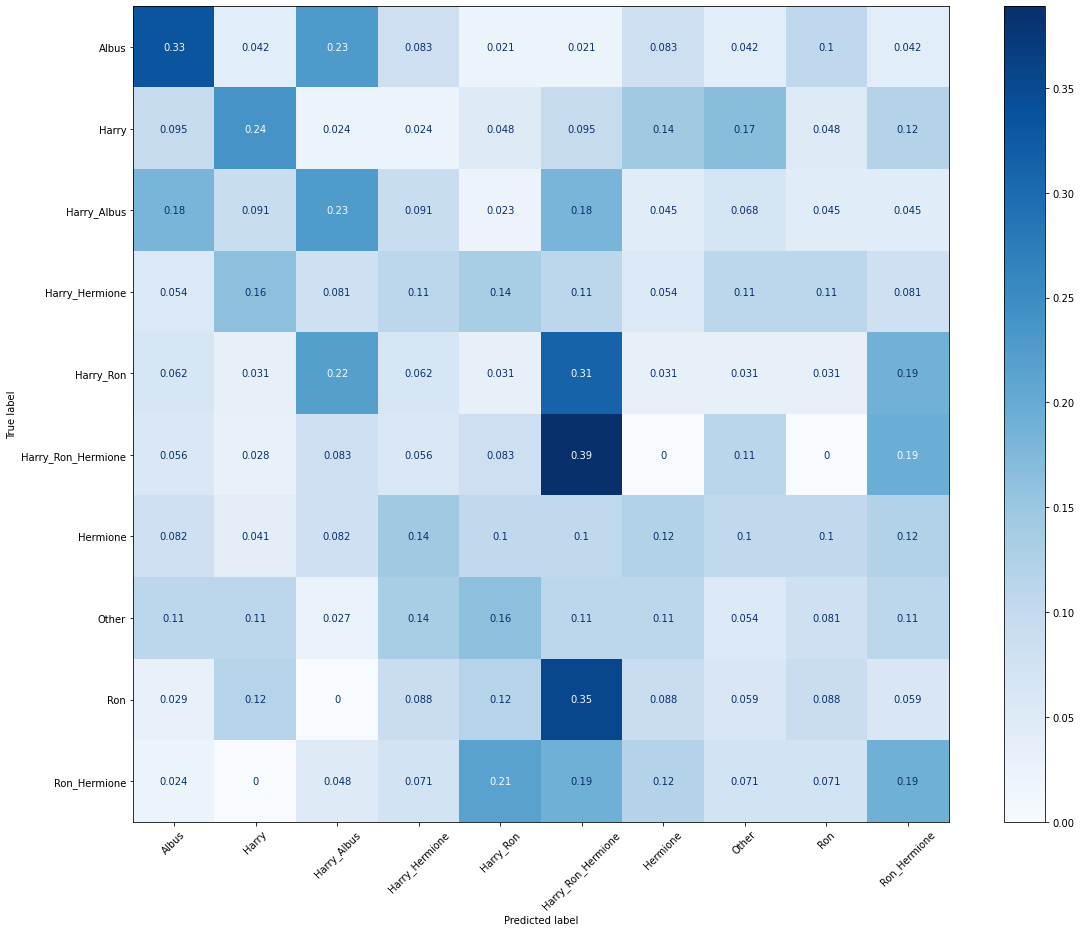

In [167]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model's performance
plt.rcParams['figure.figsize'] = [20, 15]
cm = confusion_matrix(test_labels, predict, normalize = 'true') 

cmd = ConfusionMatrixDisplay(cm, display_labels=liste_unique_labels)
cmd.plot(cmap=plt.cm.Blues, xticks_rotation=45)



# We then attempt the same task with an attention-seeking algorithm

In [15]:
torch.cuda.empty_cache()

Like above, we create a train test split with balanced data.

In [16]:
from sklearn.utils import shuffle
new_data = []
new_labs = []
shuffled_data, shuffled_labels = shuffle(special_data, numeric_stratify_labels)

for label in np.unique(numeric_stratify_labels):
  j = 0
  i = 0
  for lab in shuffled_labels:
    if lab == label and j <= 500:
      new_data.append(shuffled_data[i])
      new_labs.append(shuffled_labels[i])
      j = j+1
    i = i+1
  
new_data, new_labs = shuffle(new_data, new_labs)

In [17]:
train_text, temp_text, train_labels, temp_labels = train_test_split(new_data, new_labs, 
                                                                    random_state=seed, 
                                                                    test_size=0.3) 
BOOL = [label in numeric_stratify_labels for label in temp_labels]
temp_stratify_label = list(compress(stratify_labels, BOOL))
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=seed, 
                                                                test_size=0.5)

For this task, we resort to use a BERT pretrained model. BERT is a state of the art model that has proven to be highly performant in induction tasks. Thus, it makes a perfect candidate for a prediction relying on the meaning conveyed by the surrounding context to predict the presence of a character in an exercpt.

In [18]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

We use the tokenizer of the BertTokenizerFast object from the transformers library, to which we append the mask we have put on proper nouns inside the text (while we do not want the algorithm to know the presence of a specific character in an excerpt, it may still be relevant for him to understand that people are present in the narration). 

In [19]:
new_tokens = ['charoffocus']
num_added_toks = tokenizer.add_tokens(new_tokens)

We tokenize the dataset.

In [20]:
max_seq_len = 100

tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
tokens_val = tokenizer.batch_encode_plus(
    val_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [21]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)
# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

We start to define the functions that we will be using to train the classification algorithm. 

In [22]:
#define a batch size
batch_size = 16 # formerly 32
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [23]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [24]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert       
      # dropout layer
      self.dropout = nn.Dropout(0.1)      
      # relu activation function
      self.relu =  nn.ReLU()
      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,len(np.unique(numeric_stratify_labels)))
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)
    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)
      return x

In [25]:
bert.resize_token_embeddings(len(tokenizer))
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
#model = model.to(device)

In [26]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [27]:
#compute the class weights
class_wts = compute_class_weight('balanced', classes = np.unique(train_labels), y = train_labels)
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
#cross_entropy  = nn.NLLLoss(weight=weights) (a priori pas besoin puisque on a stratifié)
cross_entropy  = nn.NLLLoss(reduction = 'mean')

In [28]:
torch.cuda.empty_cache()

In [29]:
# function to train the model
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)**2
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds

In [30]:
# function for evaluating the model
def evaluate():
  print("\nEvaluating...")
  # deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0, 0
  # empty list to save the model predictions
  total_preds = []
  # iterate over batches
  for step, batch in enumerate(val_dataloader):
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
#      elapsed = format_time(time.time() - t0)
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    # deactivate autograd
    with torch.no_grad():
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

Launching training.

In [31]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
model = model.to(device)
# set initial loss to infinite
best_valid_loss = float('inf')
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
# number of training epochs
epochs = 5
#for each epoch
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss, _ = train()
    #evaluate model
    valid_loss, _ = evaluate()
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    220.
  Batch   100  of    220.
  Batch   150  of    220.
  Batch   200  of    220.

Evaluating...

Training Loss: 5.399
Validation Loss: 2.271

 Epoch 2 / 5
  Batch    50  of    220.
  Batch   100  of    220.
  Batch   150  of    220.
  Batch   200  of    220.

Evaluating...

Training Loss: 4.959
Validation Loss: 2.215

 Epoch 3 / 5
  Batch    50  of    220.
  Batch   100  of    220.
  Batch   150  of    220.
  Batch   200  of    220.

Evaluating...

Training Loss: 3.924
Validation Loss: 2.208

 Epoch 4 / 5
  Batch    50  of    220.
  Batch   100  of    220.
  Batch   150  of    220.
  Batch   200  of    220.

Evaluating...

Training Loss: 2.867
Validation Loss: 2.435

 Epoch 5 / 5
  Batch    50  of    220.
  Batch   100  of    220.
  Batch   150  of    220.
  Batch   200  of    220.

Evaluating...

Training Loss: 1.877
Validation Loss: 3.138


Evaluating prediction results.

In [32]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device)) # formerly test_seq and test_maks with ".to(device)"
  preds = preds.detach().cpu().numpy()

In [164]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

AxisError: ignored

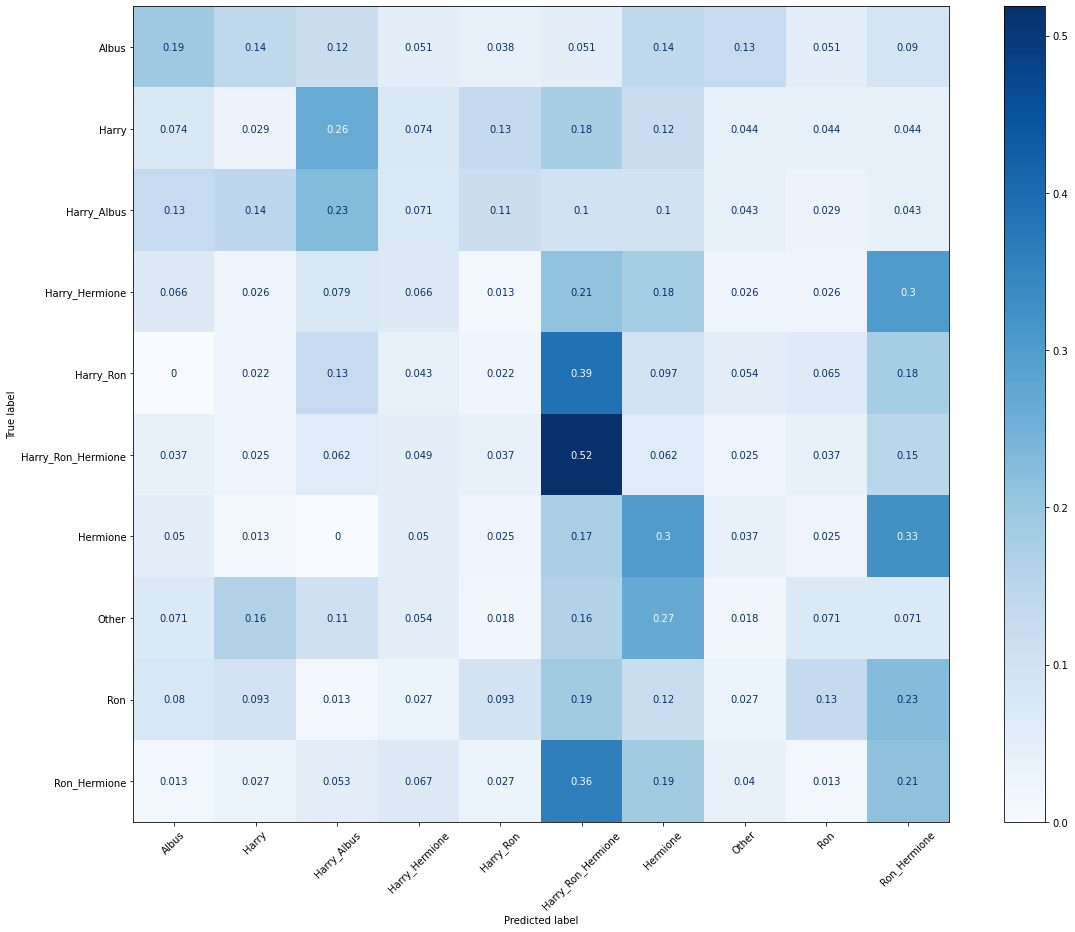

In [165]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model's performance
plt.rcParams['figure.figsize'] = [20, 15]
cm = confusion_matrix(test_y, preds, normalize = 'true') 

cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(stratify_labels))
cmd.plot(cmap=plt.cm.Blues, xticks_rotation=45)

# Comparison of predictions

We use both algorithms to predict the labels of the whole dataset. 

In [51]:
import torch.nn.functional as F

In [195]:
numeric_stratify_labels
predict = clf.predict_proba(para_coord)

In [82]:
torch.cuda.empty_cache()

# Random Forest predictions
numeric_stratify_labels
predict = clf.predict_proba(para_coord)

# BERT predictions
tokens = tokenizer.batch_encode_plus(
    special_data,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

seq = torch.tensor(tokens['input_ids'])
mask = torch.tensor(tokens['attention_mask'])
y = torch.tensor(numeric_stratify_labels)

pred = []
threshold_top = -1
nb_parts = 50
for i in tqdm(range(0,nb_parts+10)) :
  threshold_bottom = threshold_top+1
  threshold_top = min(int(len(seq)/nb_parts) + threshold_top, len(seq)-1)
  with torch.no_grad():
    preds_part = model(seq[threshold_bottom:threshold_top].to(device), mask[threshold_bottom:threshold_top].to(device))  
    probabilities = F.softmax(preds_part, dim=-1)
    probabilities = probabilities.detach().cpu().numpy()
  pred.append(probabilities)
#pred = np.concatenate(pred, preds_part)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 60/60 [04:01<00:00,  4.03s/it]


In [83]:
pred_test = [np.around(item,2) for sublist in pred for item in sublist]
np.shape(pred_test)

(20880, 10)

In [196]:
# pred_df = dict({'labels' : numeric_stratify_labels, 'true_label' : stratify_labels, 'W2V_RF_pred' : predict, 'BERT_pred' : pred})
average_pred = (predict[:20880] + pred_test)/2 
pred_diff = abs(predict[:20880] - pred_test)
argmax_pred = [np.argmax(item) for item in average_pred]
diff_pred = [np.argmax(item) for item in pred_diff]

In [197]:
argmax_pred_test = [np.argmax(item) for item in pred_test]
argmax_predict = [np.argmax(item) for item in predict[:20880]]


In [198]:
diff_pred = [np.argmax(item) for item in pred_diff]

In [199]:
albus_0 = [item[0] for item in predict[:20880]]
albus_1 = [item[0] for item in pred_test]

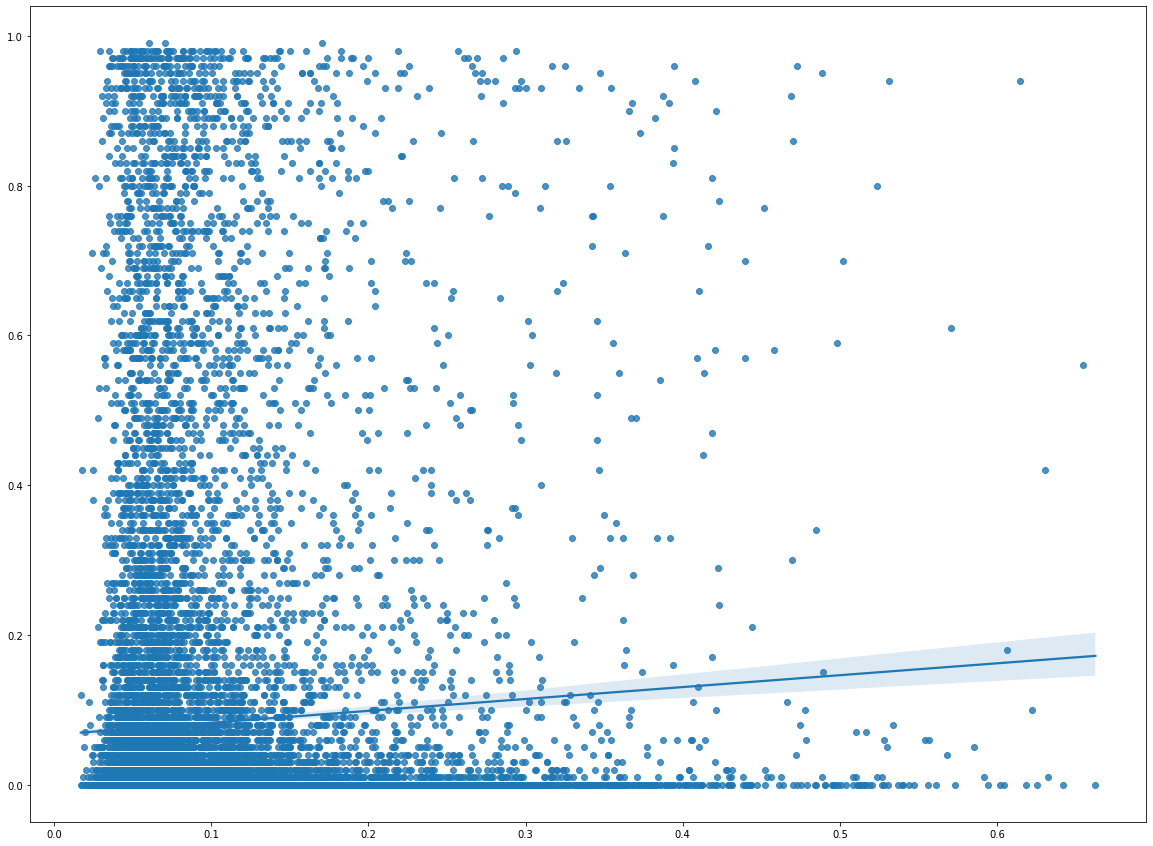

In [200]:
import seaborn as sns
sns.regplot(x=albus_0,
            y=albus_1)

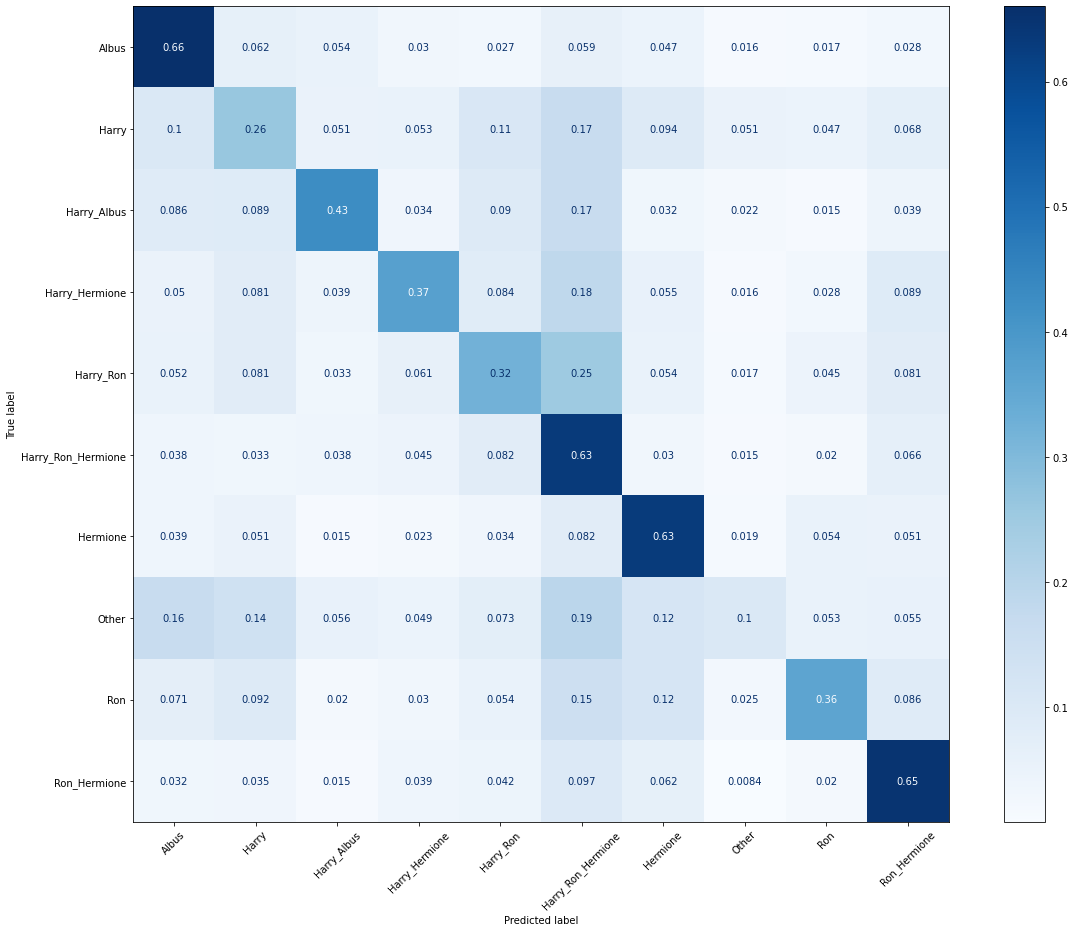

In [201]:
# model's performance
plt.rcParams['figure.figsize'] = [20, 15]
cm = confusion_matrix(numeric_stratify_labels[:20880], argmax_predict, normalize = 'true') 

cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(stratify_labels))
cmd.plot(cmap=plt.cm.Blues, xticks_rotation=45)

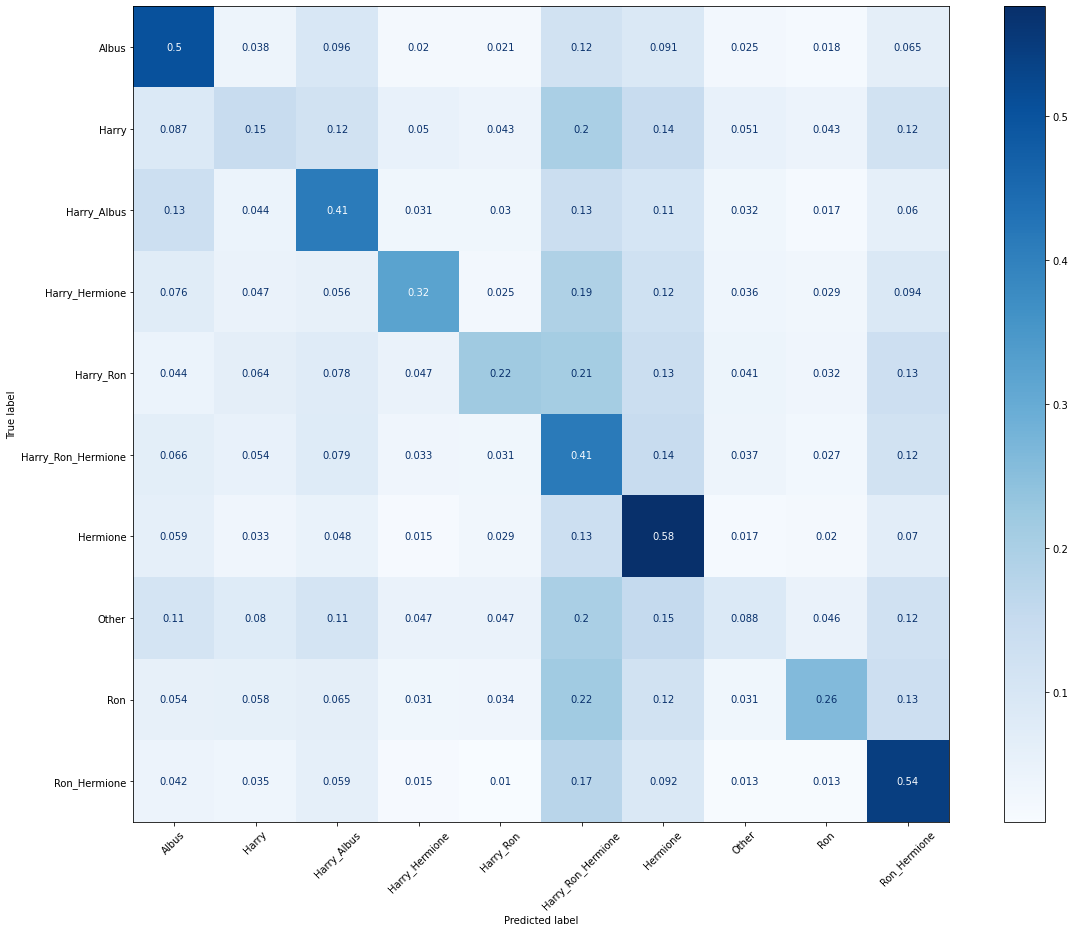

In [115]:
# model's performance
plt.rcParams['figure.figsize'] = [20, 15]
cm = confusion_matrix(numeric_stratify_labels[:20880], argmax_pred, normalize = 'true') 

cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(stratify_labels))
cmd.plot(cmap=plt.cm.Blues, xticks_rotation=45)